# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.799574,False,-2.222250
1,-0.737407,False,-2.224681
2,-0.672699,False,-0.310463
3,-0.292894,False,0.063853
4,-0.797484,False,-0.707155
...,...,...,...
995,-0.347469,False,-1.855070
996,-1.389722,False,-2.986093
997,-2.231572,False,-3.209537
998,0.966287,True,8.500667


<Axes: xlabel='v0'>

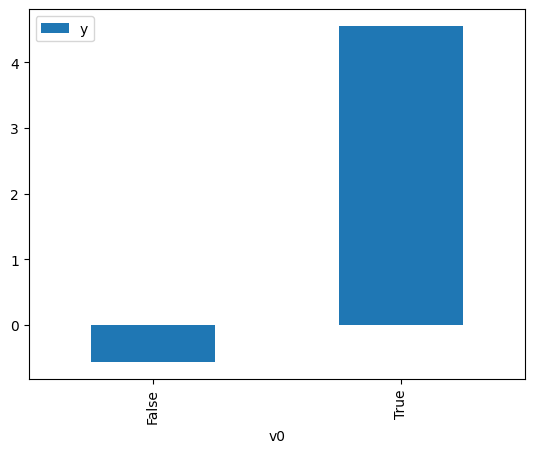

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

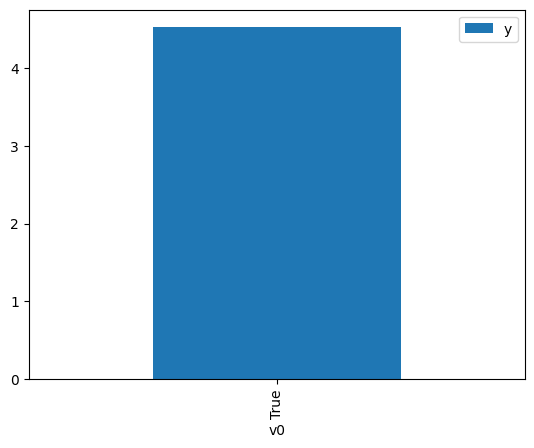

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.169585,False,-3.266827,0.885860,1.128847
1,-1.130861,False,-2.356686,0.878966,1.137700
2,-0.519769,False,-0.747075,0.717883,1.392986
3,-0.604299,False,-0.230841,0.746313,1.339920
4,-1.593866,False,-2.548133,0.941433,1.062210
...,...,...,...,...,...
995,-0.184888,False,0.105723,0.588869,1.698170
996,-1.320264,False,-3.206636,0.909514,1.099489
997,-0.425971,False,-3.558896,0.684173,1.461619
998,-1.662963,False,-2.732214,0.947639,1.055254


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.878275,True,3.738064,0.175200,5.707765
1,-1.633596,True,3.654109,0.054919,18.208768
2,-0.980423,True,3.596465,0.151291,6.609774
3,-0.593374,True,4.980309,0.257253,3.887226
4,-0.069336,True,4.999307,0.459838,2.174679
...,...,...,...,...,...
995,-1.633596,True,3.654109,0.054919,18.208768
996,1.183053,True,6.333512,0.879556,1.136938
997,-0.108787,True,3.815421,0.443074,2.256961
998,-1.463084,True,3.065036,0.072238,13.843066


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7464.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):                        0.00
Time:                        10:38:29   Log-Likelihood:                         -1418.4
No. Observations:                1000   AIC:                                      2841.
Df Residuals:                     998   BIC:                                      2851.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5987      0.030     53.322      0.000       1.540       1.658
x2             4.9770      0.052     96.471      0.000       4.876       5.078
==============================================================================
Omnibus:                        2.659   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.605
Skew:                          -0.125   Prob(JB):                        0.272
Kurtosis:                       3.015   Cond. No.                         1.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""